# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3D Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

# Load Libraries

In [24]:
# Set-up and load libraries
import os
import glob
import h5py
import numpy as np
import pandas as pd


# Tensorflow and Keras...
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import GlobalMaxPooling1D
from keras.utils import plot_model
from keras.models import Model


# plot and others...
from matplotlib import pyplot as plt
import trimesh
import seaborn as sns
from matplotlib.animation import FuncAnimation
from sklearn.metrics import classification_report
from tqdm import tqdm
# set seed
tf.random.set_seed(1234)

# Config and parameters

In [2]:
num_cloud_points = 1024
point_cloud_size = (num_cloud_points, 3)
image_size = (30, 30, 1)
num_classes = 10


epochs = 2
batch_size = 32
patience = 1

run_type = 'demo'
# run_type = 'full'

# Load MNIST (2D + 3D) Dataset

In [3]:
# data directory
DATADIR = '../data/multimodal/mnist3d/'

In [4]:
def load_data(data_type, num_pcs):
    '''
    Load train and test data: 2D images, 3D point clouds and labels

    arg:
    data_type: 'train' or 'test'

    return:
    x_2d: 2D images 
    x_3d: 3D pointcloud
    y: labels
    '''
    print(f"Loading {data_type} data......")

    with h5py.File(DATADIR + f'{data_type}_point_clouds.h5', 'r') as points_dataset:

        # Array to store data...
        x_2d = []
        x_3d = []
        y = [] 

        # Looping over the whole dataset..
        for i, (key, sample) in enumerate(points_dataset.items()):
            
            # Saving images...
            x_2d.append(sample['img'][:])

            # Sampling point cloud and saving...
            pointCloud = sample['points'][:]
            num_of_rows = pointCloud.shape[0]
            random_ind = np.random.choice(num_of_rows, size=num_pcs, replace=False)
            pointCloud = pointCloud[random_ind, :]
            x_3d.append(pointCloud)

            # Ssaving labels...
            y.append(sample.attrs['label'])

    # converting to np array...
    x_2d = np.stack(x_2d).reshape(-1, 30, 30, 1)
    x_3d = np.stack(x_3d)
    
    # convert class vectors to binary class matrices
    y = keras.utils.to_categorical(np.array(y), num_classes)  

    # Dropping samples if running as a demo...
    
    # Total samples..............
    total_samples = x_3d.shape[0]
    # Taking random indices for resampling
    random_indices = np.arange(total_samples)
    np.random.shuffle(random_indices)

    # checking the run_type
    if run_type == 'demo':
        print(f"Original shape of 2D samples: {x_2d.shape}")
        print(f"Original shape of 3D samples: {x_3d.shape}")
        demo_samples = 100
        random_indices = random_indices[0:demo_samples]

    # Selecting training and test samples...
    x_2d = x_2d[random_indices]
    x_3d = x_3d[random_indices]
    y = y[random_indices]
   
    # Done loading and processing dataset...
    # print(f"{data_type} data loaded...!")
    print(f"_______________________________________________")
    print(f"Loaded shape of 2D samples: {x_2d.shape}")
    print(f"Loaded shape of 3D samples: {x_3d.shape}")
    print("\n")
    # return image, pointclouds, and labels
    return x_2d, x_3d, y

In [6]:
# Loading training data
x_train_2d, x_train_3d, y_train = load_data(data_type = 'train', num_pcs = num_cloud_points)
y_train_digit = np.argmax(y_train, axis=1) # Convert one-hot to index

# Loading test data
x_test_2d, x_test_3d, y_test = load_data(data_type = 'test', num_pcs = num_cloud_points)
y_test_digit = np.argmax(y_test, axis=1) # Convert one-hot to index
y_test_df = pd.DataFrame(y_test_digit, columns = ['Label'])

x_train_dict = {}
x_train_dict['2D'] = x_train_2d
x_train_dict['3D'] = x_train_3d
x_train_dict['Fusion'] = [x_train_2d, x_train_3d]

x_test_dict = {}
x_test_dict['2D'] = x_test_2d
x_test_dict['3D'] = x_test_3d
x_test_dict['Fusion'] = [x_test_2d, x_test_3d]

# Creating input for adv sample generation
y_test_df_samp = y_test_df.groupby('Label', group_keys=False).apply(lambda x: x.sample(3))
y_plot_df_samp = y_test_df_samp.reset_index(drop=True).groupby('Label', group_keys=False).apply(lambda x: x.sample(1))


test_ind = y_test_df_samp.index
plot_ind = y_plot_df_samp.index

x_actual_dict = {}
x_actual_dict['2D'] = tf.convert_to_tensor(x_test_2d[test_ind])
x_actual_dict['3D'] = tf.convert_to_tensor(x_test_3d[test_ind])
x_actual_dict['Fusion'] = [x_actual_dict['2D'], x_actual_dict['3D']]
y_actual = tf.convert_to_tensor(y_test[test_ind])
y_actual_digit = y_test_df_samp['Label'].values

# Loss object..
loss_func = tf.keras.losses.CategoricalCrossentropy()

Loading train data......
Original shape of 2D samples: (5000, 30, 30, 1)
Original shape of 3D samples: (5000, 1024, 3)
_______________________________________________
Loaded shape of 2D samples: (100, 30, 30, 1)
Loaded shape of 3D samples: (100, 1024, 3)


Loading test data......
Original shape of 2D samples: (1000, 30, 30, 1)
Original shape of 3D samples: (1000, 1024, 3)
_______________________________________________
Loaded shape of 2D samples: (100, 30, 30, 1)
Loaded shape of 3D samples: (100, 1024, 3)




2022-12-04 22:34:10.491625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 22:34:10.518190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 22:34:10.518346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 22:34:10.518756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
# Functions 
def train_and_evaluate(model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience):
    """  
    arg: model and other info
    return: trained model & eval data
    """
    # Train and evaluate model
    # Starting the training...
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)
    history = model.fit(x_train_dict[model_type], y_train, batch_size=batch_size
    , epochs=epochs, validation_split=0.1, callbacks=[callback])

    # Evaluate model on test data...
    accuracy = model.evaluate(x_test_dict[model_type], y_test, batch_size=56)[1]
    # print(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")

    plt.figure()
    plt.plot(history.history['loss'], marker = 'p')
    plt.title(f"Test Accuracy of {model_name}: {np.round(accuracy*100,5)}%")
    plt.show()

    # Classification matrix...
    y_pred = np.argmax(model.predict(x_test_dict[model_type]), axis=1)
    cls_rep = classification_report(y_test_digit, y_pred) 

    model_eval = {
        'fusion_type': fusion_type,
        'fusion_layer': fusion_layer,
        'model': model,
        'model_name' : model_name,
        'model_type': model_type,
        'history': history,
        'accuracy': accuracy,
        'cls_rep' : cls_rep
    }   
    #-------------------------
    return model_eval

def visualize_prediction(model_name, model_type, model, vis_type):
    """ 
    Visualize the prediction performance
    arg: 
    model_type: '2D' , '3D' or 'Fusion'
    model: keras model

    return:
    plot the first 10 samples with predicted labels
    """
    
    # Visualize predictions and images...
    noOfsamples = 5 if model_type =='Fusion' else 10
    if vis_type == 'Actual':
        # images, points, labels = x_test_2d[:noOfsamples], x_test_3d[:noOfsamples], y_test[:noOfsamples]
        images, points, labels = x_actual_dict['2D'].numpy()[plot_ind][:noOfsamples], x_actual_dict['3D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]
        
    elif vis_type == 'Adversarial':
        if model_type =='2D' or model_type =='Fusion':
            images, labels = x_adv_dict['2D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]
        if model_type =='3D' or model_type =='Fusion':
            points, labels = x_adv_dict['3D'].numpy()[plot_ind][:noOfsamples], y_actual.numpy()[plot_ind][:noOfsamples]

    # Setting up input data for the prediction
    if model_type == '2D':
        input_data = images
    elif model_type == '3D':
        input_data = points
    elif model_type =='Fusion':
        input_data = [images, points]
        

    # run test data through model
    
    if vis_type == 'Actual':
        preds = model.predict(input_data)
        preds = tf.math.argmax(preds, -1).numpy()
    else:
        preds = y_adv_pred_digit[0:noOfsamples]
        # labels = y_actual_digit[0:noOfsamples]
    
    labels = np.argmax(labels, axis = 1)


    # plot points with predicted class and label
    fig = plt.figure(figsize=(12, 5))
    # Looping over the input sample to visualization
    for i in range(noOfsamples):
        # print(f"pred: {preds[i]}, label: {labels[i]}") 
        
        if model_type == '2D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = i+1
            ax = fig.add_subplot(2, 5, index)
            ax.imshow(images[i, :, :, 0])
            ax.set_title(
                "Pred: {:}, Label: {:}".format(
                    preds[i], labels[i]
                )
            )
            ax.set_axis_off()

        if model_type == '3D' or model_type == 'Fusion':
            if model_type != 'Fusion':
                index = i+1
            else:
                index = noOfsamples+i+1
            ax = fig.add_subplot(2, 5, index, projection="3d")    
            ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2], marker='.')
            # ax.set_axis_off()
            if model_type != 'Fusion':
                ax.set_title("Pred: {:}, Label: {:}".format(
                    preds[i], labels[i]))
            ax.set_xticks([])
            ax.grid(True)
            ax.view_init(0, 10)
    plt.show()

# Creating Models to extract features

In [8]:
# Functions for building the models.......

# Convolution with batch normalization...
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Dense with batch normalization...
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Transormation Network (T-Net)...
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        # activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


In [9]:
# CNN Model to extract 128 features from 2D MNIST dataset
inputs_2D = Input(shape=image_size)
feat_2d = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs_2D)
feat_2d = MaxPooling2D(pool_size=(2, 2))(feat_2d)
feat_2d = Conv2D(64, kernel_size=(3, 3), activation="relu")(feat_2d)
feat_2d = MaxPooling2D(pool_size=(2, 2))(feat_2d)
feat_2d = Flatten()(feat_2d)
feat_2d = Dropout(0.3)(feat_2d)
feat_2d = Dense(128, activation="relu")(feat_2d)
# Creating the model to extract features from input images
model_feat_ext_2D = Model(inputs=inputs_2D, outputs=feat_2d,  name="feature-extractor-2D")
print(model_feat_ext_2D.summary())

Model: "feature-extractor-2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)     

In [10]:
# Pointnet model to extract 128 features from 3D MNIST dataset
inputs_3D = Input(shape= point_cloud_size)

feat_3D = tnet(inputs_3D, 3)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = tnet(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 32)
feat_3D = conv_bn(feat_3D, 64)
feat_3D = conv_bn(feat_3D, 512)
feat_3D = GlobalMaxPooling1D()(feat_3D)
feat_3D = dense_bn(feat_3D, 256)
feat_3D = Dropout(0.3)(feat_3D)
feat_3D = dense_bn(feat_3D, 128)
# Creating the model to extract features from input point cluds
model_feat_ext_3D = Model(inputs=inputs_3D, outputs=feat_3D,  name="feature-extractor-3D")
print(model_feat_ext_3D.summary())


Model: "feature-extractor-3D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     128         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024, 32)     0           ['batch_normal

In [11]:
# Storing model eval data...
model_eval_dict = {}

## Creating 2D CNN-based Classifier

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 feature-extractor-2D (Funct  (None, 128)              313856    
 ional)                                                          
                                                                 
 model (Functional)          (None, 10)                1290      
                                                                 
Total params: 315,146
Trainable params: 315,146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2


2022-12-04 22:34:30.442113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2022-12-04 22:34:30.645389: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-04 22:34:30.948400: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3d0f5e8070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-04 22:34:30.948425: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2022-12-04 22:34:30.952267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER

3/3 [==============================] - ETA: 0s - loss: 2.2745 - accuracy: 0.1333

2022-12-04 22:34:31.794896: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/3 [==============================] - 2s 142ms/step - loss: 2.2745 - accuracy: 0.1333 - val_loss: 2.2937 - val_accuracy: 0.1000
Epoch 2/2
2/2 [==============================] - 0s 43ms/step - loss: 2.0970 - accuracy: 0.2500


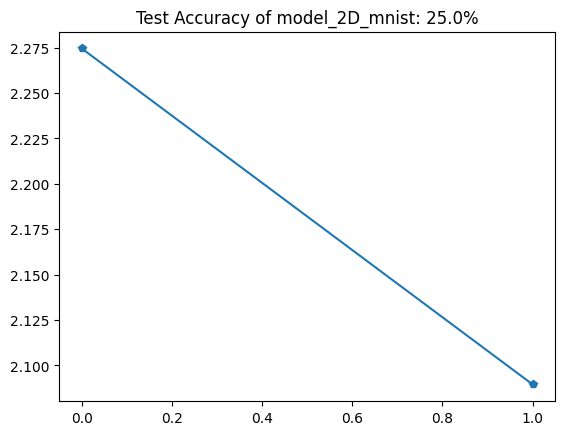

1/1 [==============================] - 0s 15ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

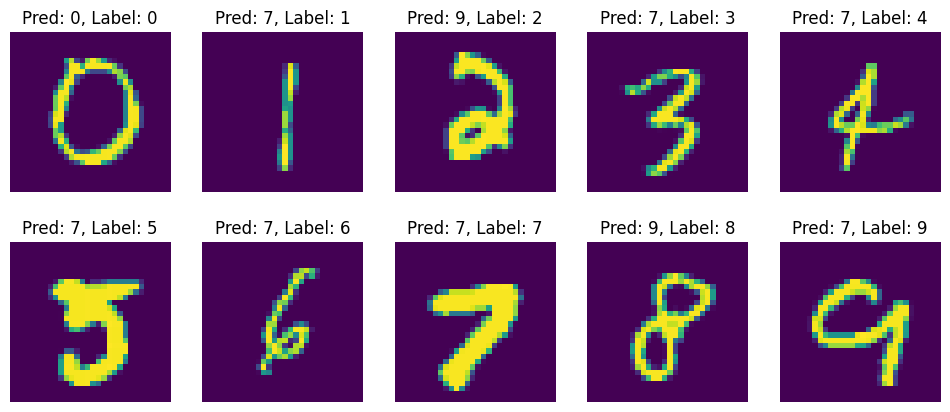

In [12]:
# Model to predict score for 128 features for MNIST
feats_extracted_2D = Input(shape= feat_2d.shape[1:])  
output_pred_2D = Dense(num_classes, activation="softmax")(feats_extracted_2D)
model_pred_scores_2D = Model(feats_extracted_2D, output_pred_2D)
# model_pred_scores_2D.summary()

# Model 2D CNN-based Classifier for MNIST 2D
# Complete CNN model for MNIST 2D Dataset
model_2D_mnist = keras.Model(inputs_2D, model_pred_scores_2D(model_feat_ext_2D(inputs_2D)))
model_2D_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model_2D_mnist.summary())


model_name = 'model_2D_mnist'
model = model_2D_mnist
model_type = '2D'
fusion_type = None
fusion_layer = None

# Train and evaluate...
model_eval_dict[model_name]= train_and_evaluate(
    model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience)
# # Visualize the prediction on 3D point clouds
visualize_prediction(model_name, model_type, model, vis_type= 'Actual')

## Creating 3D Pointnet-based Classifier

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 3)]         0         
                                                                 
 feature-extractor-3D (Funct  (None, 128)              747689    
 ional)                                                          
                                                                 
 model_2 (Functional)        (None, 10)                1290      
                                                                 
Total params: 748,979
Trainable params: 742,899
Non-trainable params: 6,080
_________________________________________________________________
None
Epoch 1/2


2022-12-04 22:34:39.964725: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-04 22:34:40.116493: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-04 22:34:40.276812: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

3/3 [==============================] - 11s 478ms/step - loss: 2.3304 - accuracy: 0.1667 - val_loss: 5.9992 - val_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 115ms/step - loss: 2.3551 - accuracy: 0.3000


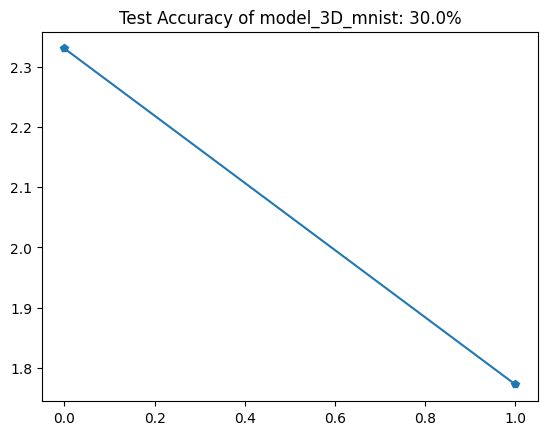

1/1 [==============================] - 0s 16ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

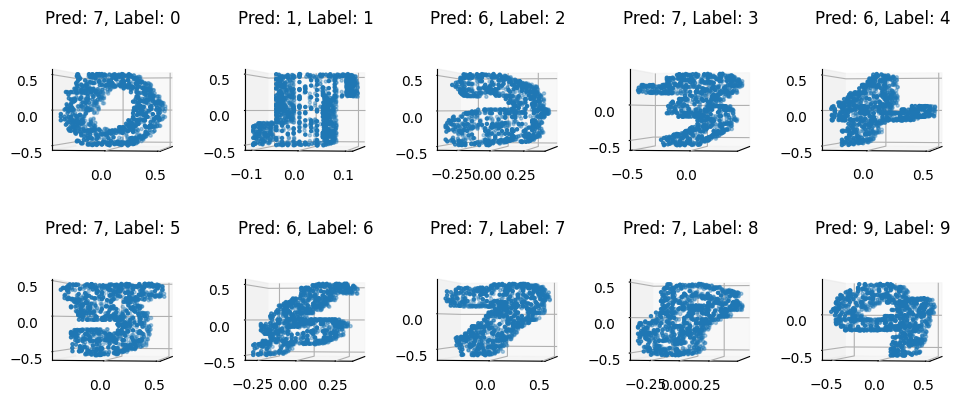

In [13]:
# Model to predict score for 128 features for MNIST 3D dataset
feats_extracted_3D = Input(shape= feat_3D.shape[1:])  
output_pred_3D = Dense(num_classes, activation="softmax")(feats_extracted_3D)
model_pred_scores_3D = Model(feats_extracted_3D, output_pred_3D)
# model_pred_scores_3D.summary()

# Model Pointnet Classifier for MNIST 3D
model_3D_mnist = keras.Model(inputs_3D, model_pred_scores_3D(model_feat_ext_3D(inputs_3D)))
model_3D_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model_3D_mnist.summary())




model_name = 'model_3D_mnist'
model = model_3D_mnist
model_type = '3D'
fusion_type = None
fusion_layer = None

# epochs = 1 
# batch_size = 32
# patience = 5
# x_train = x_train_3d
# x_test = x_test_3d

# Train and evaluate...
model_eval_dict[model_name]= train_and_evaluate(
    model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience)

# # Visualize the prediction on 3D point clouds
visualize_prediction(model_name, model_type, model, vis_type= 'Actual')

# Create Fusion Models

In [14]:
# Create Late Fusion Models with different fusion layers
from keras.layers import Concatenate, Average,Maximum, Minimum, Add, Subtract, Multiply

mid_fusion_layers_dict = {
    'concatenate': Concatenate(),
    'Average' : Average(),
    'Maximum' : Maximum(),
    'Minimum' : Minimum(),
    # 'Add': Add(),
    # 'Subtract': Subtract(),
    'Multiply': Multiply()
}


late_fusion_layers_dict = {
    'Average' : Average(),
    'Maximum' : Maximum(),
    'Minimum' : Minimum(),
    # 'Add': Add(),
    # 'Subtract': Subtract(),
    'Multiply': Multiply()
}

In [15]:
model_feat_ext_2D.trainable = False
model_feat_ext_3D.trainable = False

model_pred_scores_2D.trainable = False
model_pred_scores_3D.trainable = False

model_2D_mnist.trainable = False
model_3D_mnist.trainable = False

# model_feat_ext_2D.trainable = True
# model_feat_ext_3D.trainable = True

# model_pred_scores_2D.trainable = True
# model_pred_scores_3D.trainable = True

# model_2D_mnist.trainable = True
# model_3D_mnist.trainable = True

## Creating Late-Fusion Models

Average
Epoch 1/2
3/3 [==============================] - 2s 282ms/step - loss: 1.8303 - accuracy: 0.3556 - val_loss: 2.4145 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 68ms/step - loss: 2.0807 - accuracy: 0.3000


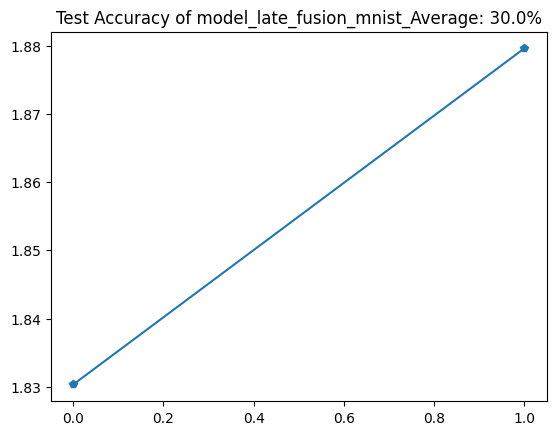

1/1 [==============================] - 0s 87ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

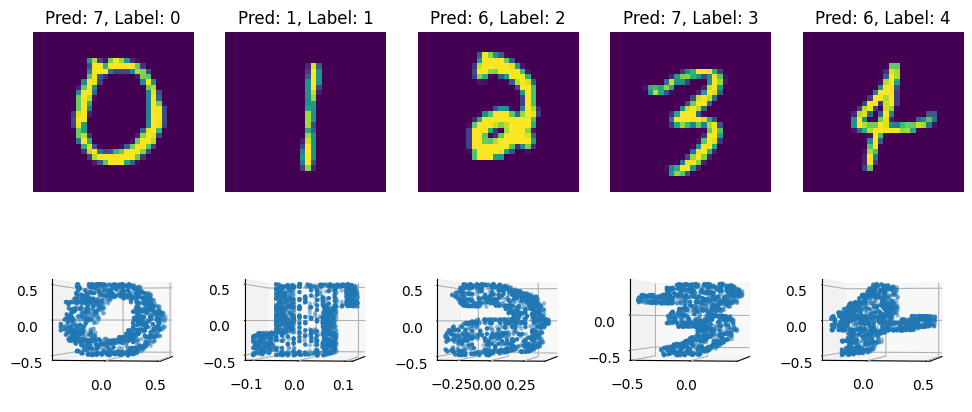

Maximum
Epoch 1/2
3/3 [==============================] - 2s 265ms/step - loss: 1.8268 - accuracy: 0.3444 - val_loss: 2.4165 - val_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 69ms/step - loss: 2.0659 - accuracy: 0.3000


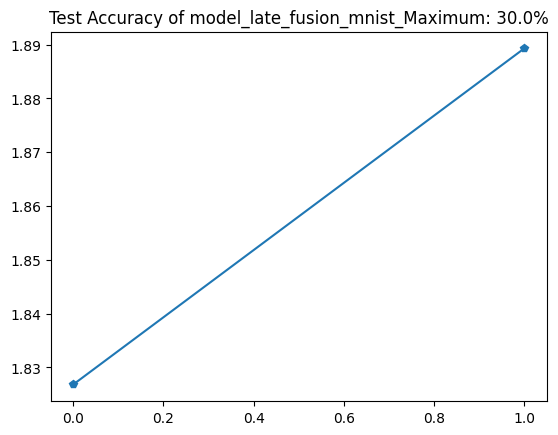

1/1 [==============================] - 0s 16ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

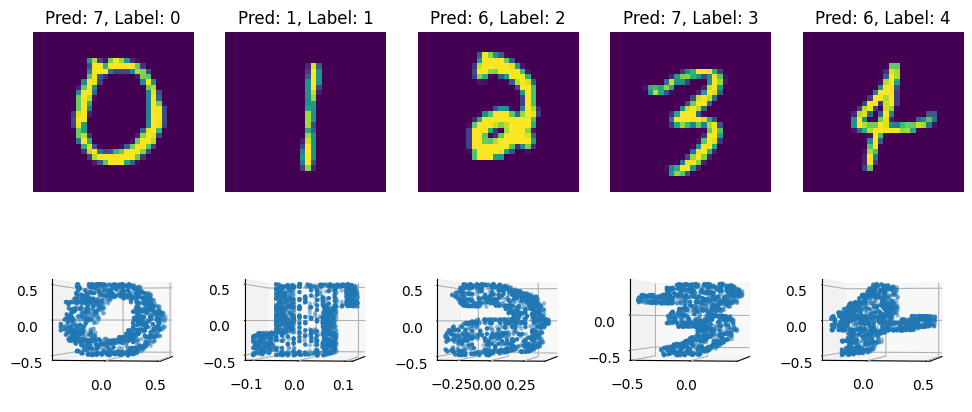

Minimum
Epoch 1/2
3/3 [==============================] - 2s 268ms/step - loss: 2.0937 - accuracy: 0.3778 - val_loss: 2.6607 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 61ms/step - loss: 2.2307 - accuracy: 0.2900


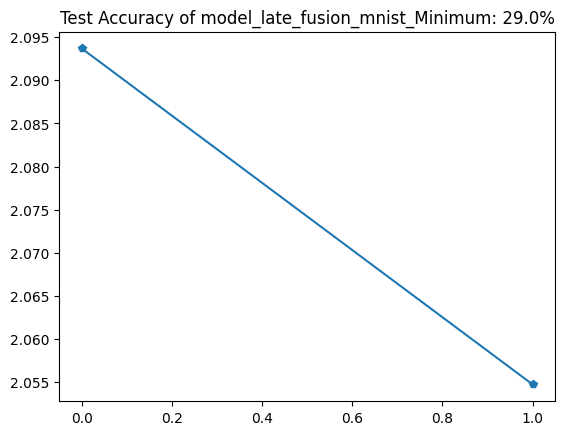

1/1 [==============================] - 0s 18ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

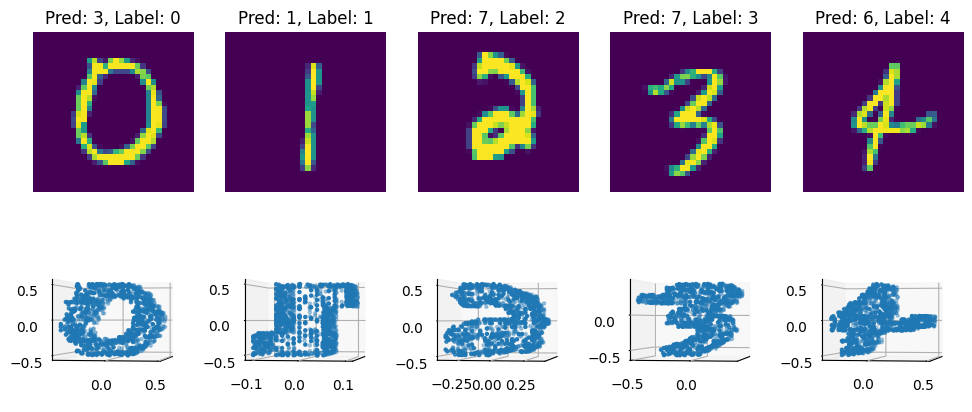

Multiply
Epoch 1/2
3/3 [==============================] - 2s 259ms/step - loss: 2.1659 - accuracy: 0.3889 - val_loss: 3.1668 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 65ms/step - loss: 2.3278 - accuracy: 0.2900


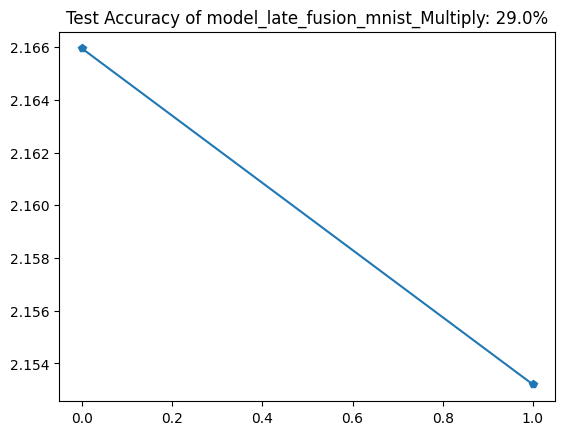

1/1 [==============================] - 0s 17ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

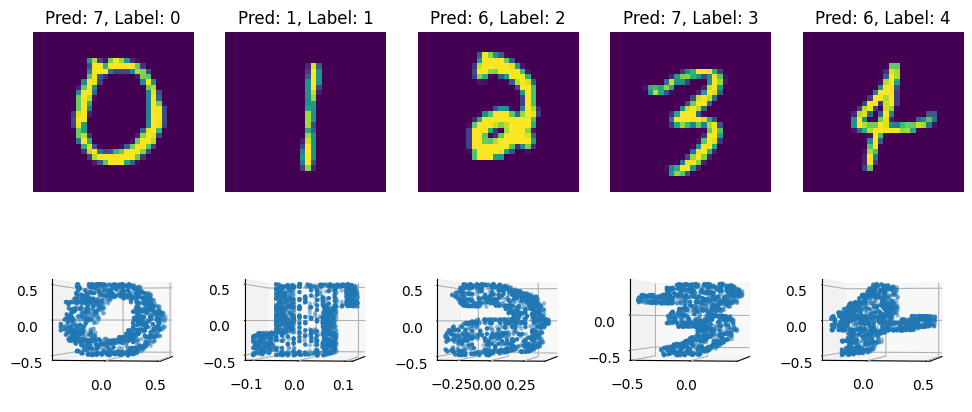

In [16]:
for fusion_layer_name, fusion_layer in late_fusion_layers_dict.items():

    print(fusion_layer_name)
    model_name = f"model_late_fusion_mnist_{fusion_layer_name}"
    
    # combine the output of the two branches
    output_pred_late_fusion = fusion_layer([model_2D_mnist.output, model_3D_mnist.output])

    # Finally combine two models and build a single multi modal mode...
    model_late_fusion_mnist = Model(inputs=[inputs_2D, inputs_3D], outputs= output_pred_late_fusion,  name = model_name)
    model_late_fusion_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # print(model_late_fusion_mnist.summary())

    model_name = model_name
    model = model_late_fusion_mnist
    model_type = 'Fusion'
    fusion_type = "Late"
    fusion_layer = fusion_layer_name
    # epochs = 2 
    # batch_size = 32
    # patience = 5
    # x_train = [x_train_2d, x_train_3d]
    # x_test = [x_test_2d, x_test_3d]

    # Train and evaluate...
    model_eval_dict[model_name]= train_and_evaluate(
        model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience)

    # # Visualize the prediction on 3D point clouds
    visualize_prediction(model_name, model_type, model, vis_type= 'Actual')

## Creating Mid Fusion Models

concatenate
Epoch 1/2


2022-12-04 22:35:49.174345: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


3/3 [==============================] - 3s 279ms/step - loss: 2.3129 - accuracy: 0.1444 - val_loss: 2.4837 - val_accuracy: 0.1000
Epoch 2/2
2/2 [==============================] - 0s 67ms/step - loss: 2.3010 - accuracy: 0.1600


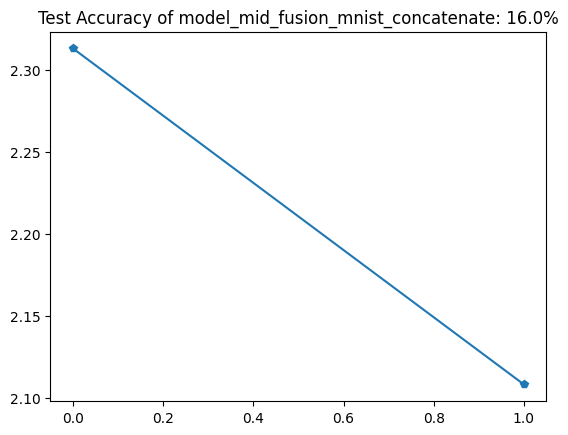

1/1 [==============================] - 0s 16ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

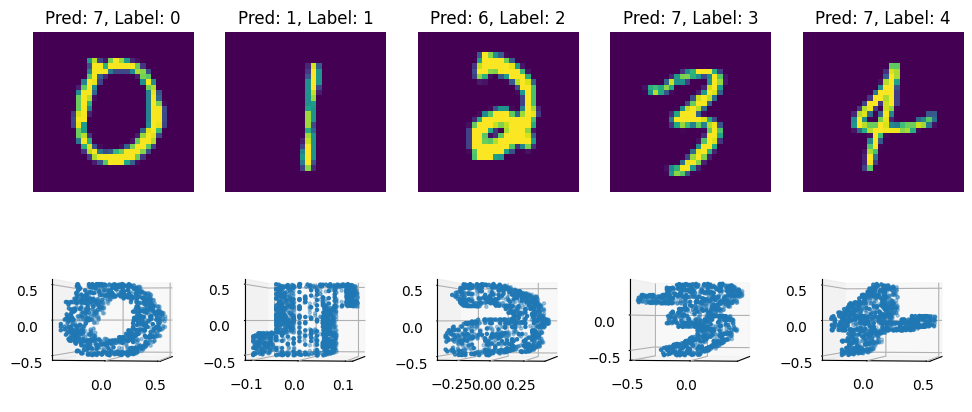

Average
Epoch 1/2
3/3 [==============================] - 3s 272ms/step - loss: 2.4034 - accuracy: 0.1222 - val_loss: 2.2825 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 62ms/step - loss: 2.2555 - accuracy: 0.1600


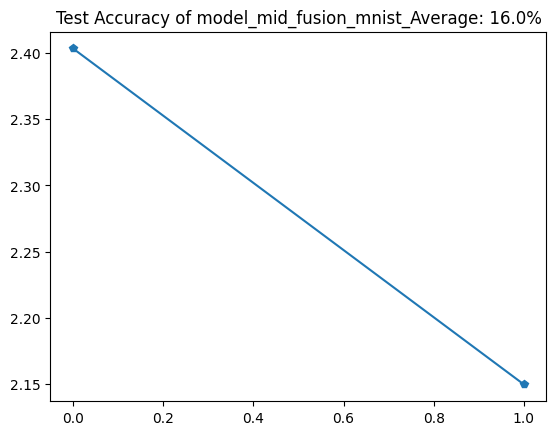

1/1 [==============================] - 0s 17ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

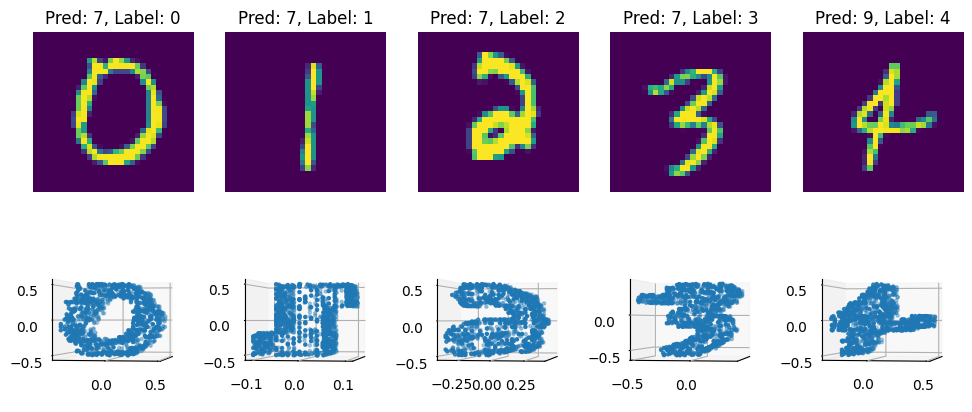

Maximum
Epoch 1/2
3/3 [==============================] - 3s 313ms/step - loss: 2.6443 - accuracy: 0.0444 - val_loss: 2.2459 - val_accuracy: 0.3000
Epoch 2/2
2/2 [==============================] - 0s 60ms/step - loss: 2.2442 - accuracy: 0.1400


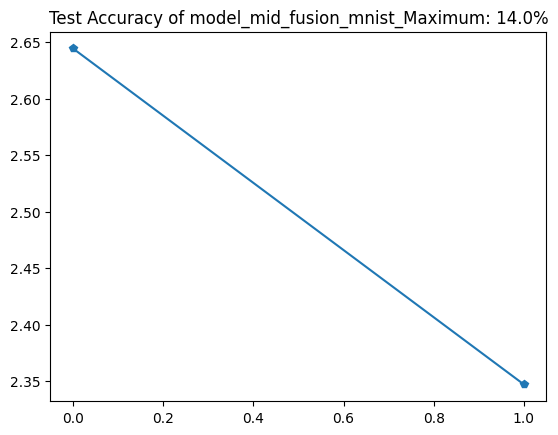

1/1 [==============================] - 0s 16ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

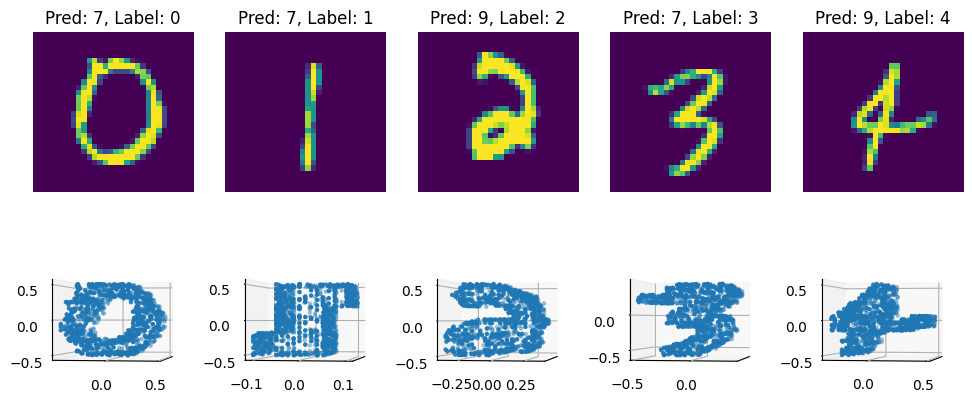

Minimum
Epoch 1/2
3/3 [==============================] - 3s 332ms/step - loss: 2.3023 - accuracy: 0.1222 - val_loss: 2.3167 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 60ms/step - loss: 2.2983 - accuracy: 0.1300


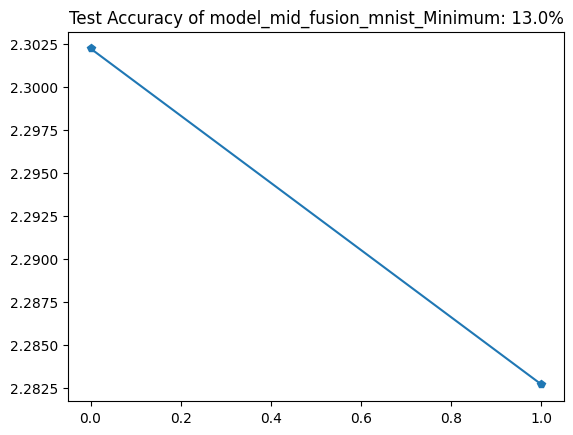

1/1 [==============================] - 0s 21ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

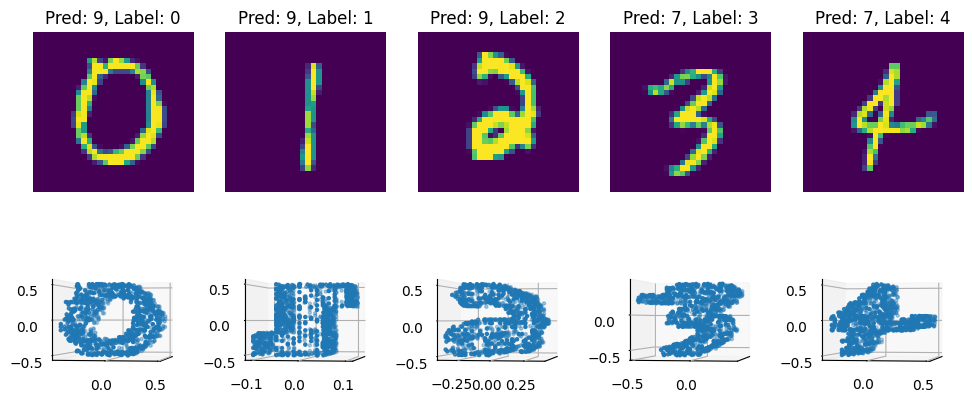

Multiply
Epoch 1/2
3/3 [==============================] - 3s 300ms/step - loss: 2.3083 - accuracy: 0.1444 - val_loss: 2.2765 - val_accuracy: 0.2000
Epoch 2/2
2/2 [==============================] - 0s 64ms/step - loss: 2.2612 - accuracy: 0.1500


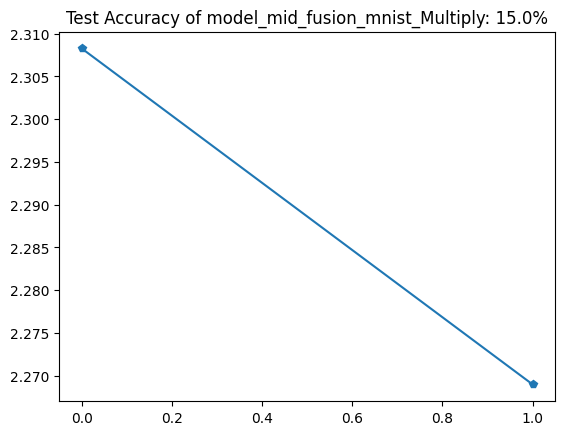

1/1 [==============================] - 0s 18ms/step


/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hasan/Desktop/softwares/multi-modal-sec/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

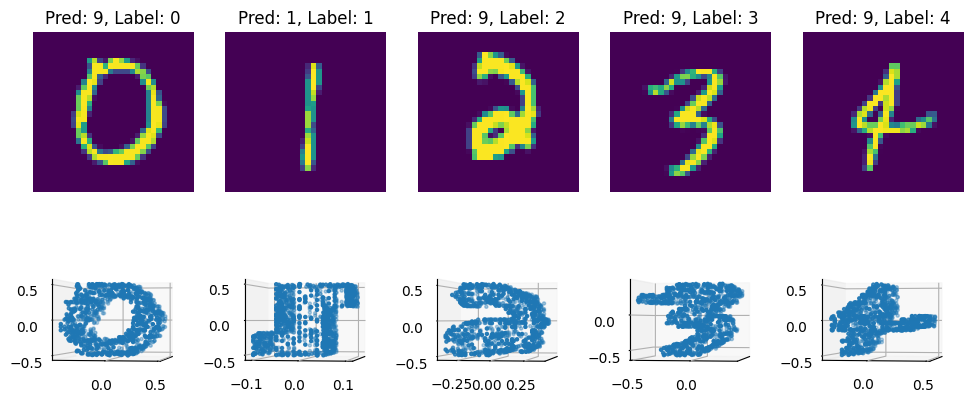

In [17]:
for fusion_layer_name, fusion_layer in mid_fusion_layers_dict.items():

    print(fusion_layer_name)
    model_name = f"model_mid_fusion_mnist_{fusion_layer_name}"
    
    # combine the output of the two branches
    output_pred_mid_fusion = fusion_layer([model_feat_ext_2D.output, model_feat_ext_3D.output])
    output_pred_mid_fusion = Dense(128, activation="relu")(output_pred_mid_fusion)
    output_pred_mid_fusion = Dense(64, activation="relu")(output_pred_mid_fusion)
    output_pred_mid_fusion = Dense(num_classes, activation="softmax")(output_pred_mid_fusion)

    # Finally combine two models and build a single multi modal mode...
    model_mid_fusion_mnist = Model(inputs=[inputs_2D, inputs_3D], outputs= output_pred_mid_fusion,  name = model_name)
    model_mid_fusion_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    # print(model_late_fusion_mnist.summary())

    model_name = model_name
    model = model_mid_fusion_mnist
    model_type = 'Fusion'
    fusion_type = "Mid"
    fusion_layer = fusion_layer_name


    # Train and evaluate...
    model_eval_dict[model_name]= train_and_evaluate(
        model_name, model_type, fusion_type, fusion_layer, model, epochs, batch_size, patience)

    # # Visualize the prediction on 3D point clouds
    visualize_prediction(model_name, model_type, model, vis_type= 'Actual')

### Savind data and model

In [25]:
feat_list = ['fusion_type', 'fusion_layer', 'model_name', 'model_type', 'accuracy']

eval_data = {}

for model_name in tqdm(model_eval_dict.keys()):
    
    value = model_eval_dict[model_name]
    values = []
    for feat in feat_list:
        values.append(value[feat])
    eval_data[model_name] = values

    model = model_eval_dict[model_name]['model']
    model.save(f'models/{model_name}')  



  0%|          | 0/11 [00:00<?, ?it/s]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_2D_mnist/assets


INFO:tensorflow:Assets written to: models/model_2D_mnist/assets
  9%|▉         | 1/11 [00:01<00:10,  1.02s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 11). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_3D_mnist/assets


INFO:tensorflow:Assets written to: models/model_3D_mnist/assets
 18%|█▊        | 2/11 [00:08<00:42,  4.76s/it]WARNING:absl:Found untraced functions such as _update_step_xla, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Average/assets


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Average/assets
 27%|██▋       | 3/11 [00:16<00:49,  6.17s/it]WARNING:absl:Found untraced functions such as _update_step_xla, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Maximum/assets


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Maximum/assets
 36%|███▋      | 4/11 [00:24<00:48,  6.88s/it]WARNING:absl:Found untraced functions such as _update_step_xla, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Minimum/assets


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Minimum/assets
 45%|████▌     | 5/11 [00:31<00:41,  6.95s/it]WARNING:absl:Found untraced functions such as _update_step_xla, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Multiply/assets


INFO:tensorflow:Assets written to: models/model_late_fusion_mnist_Multiply/assets
 55%|█████▍    | 6/11 [00:39<00:36,  7.39s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_concatenate/assets


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_concatenate/assets
 64%|██████▎   | 7/11 [00:47<00:30,  7.62s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Average/assets


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Average/assets
 73%|███████▎  | 8/11 [00:53<00:21,  7.01s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Maximum/assets


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Maximum/assets
 82%|████████▏ | 9/11 [00:59<00:13,  6.63s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Minimum/assets


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Minimum/assets
 91%|█████████ | 10/11 [01:06<00:06,  6.80s/it]WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Multiply/assets


INFO:tensorflow:Assets written to: models/model_mid_fusion_mnist_Multiply/assets
100%|██████████| 11/11 [01:12<00:00,  6.60s/it]


In [26]:
# saving model evalution data on actual dataset...
model_eval_actual = pd.DataFrame(eval_data,feat_list).T
model_eval_actual.to_csv("generated_data/model_eval_actual.csv", header = True, index = True)